In [2]:
import numpy as np # linear algebra
import scipy as scipy
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import dill

import keras as k
import cv2
from tqdm import tqdm


In [6]:
from skimage import feature

def getEdges(a):
    red_lst = list()
    green_lst = list()
    blue_lst = list()
    nir_lst = list()
    for i, image in enumerate(a):
        if i % 10000 == 0:
            print(i)
        red_lst.append(feature.canny(image[:,:,0], sigma=3))
        green_lst.append(feature.canny(image[:,:,1], sigma=3))
        blue_lst.append(feature.canny(image[:,:,2], sigma=3))
        nir_lst.append(feature.canny(image[:,:,3], sigma=3))
    temp = np.array([red_lst, green_lst, blue_lst, nir_lst])
    return temp.reshape((temp.shape[1], temp.shape[2], temp.shape[3], temp.shape[0]))


In [7]:
for i in range(2000, 43000, 2000):
    fileName = ''.join(['/Volumes/LUKE/bigTifs/bigTifs', str(i), '.pkl'])
    print(fileName)
    with open(fileName, 'rb') as in_strm:
        all_info = dill.load(in_strm)
        all_x = np.array(all_info[0], dtype=np.float64)
        edges = getEdges(all_x)
    fileNameToSave = ''.join(['/Volumes/LUKE/bigTifsWithEdges', str(i), '.pkl'])
    all_info.append(edges)
    with open(fileNameToSave, 'wb') as out_strm: 
        dill.dump(all_info, out_strm)

label_map = all_info[4]
inv_label_map = all_info[5]
print(x_train.shape)

/Volumes/LUKE/bigTifs/bigTifs2000.pkl
0
/Volumes/LUKE/bigTifs/bigTifs4000.pkl
0
/Volumes/LUKE/bigTifs/bigTifs6000.pkl
0
/Volumes/LUKE/bigTifs/bigTifs8000.pkl
0
/Volumes/LUKE/bigTifs/bigTifs10000.pkl
0
/Volumes/LUKE/bigTifs/bigTifs12000.pkl
0
/Volumes/LUKE/bigTifs/bigTifs14000.pkl
0
/Volumes/LUKE/bigTifs/bigTifs16000.pkl
0
/Volumes/LUKE/bigTifs/bigTifs18000.pkl
0
/Volumes/LUKE/bigTifs/bigTifs20000.pkl
0
/Volumes/LUKE/bigTifs/bigTifs22000.pkl
0
/Volumes/LUKE/bigTifs/bigTifs24000.pkl
0
/Volumes/LUKE/bigTifs/bigTifs26000.pkl
0
/Volumes/LUKE/bigTifs/bigTifs28000.pkl
0
/Volumes/LUKE/bigTifs/bigTifs30000.pkl
0
/Volumes/LUKE/bigTifs/bigTifs32000.pkl
0
/Volumes/LUKE/bigTifs/bigTifs34000.pkl
0
/Volumes/LUKE/bigTifs/bigTifs36000.pkl
0
/Volumes/LUKE/bigTifs/bigTifs38000.pkl
0
/Volumes/LUKE/bigTifs/bigTifs40000.pkl
0
/Volumes/LUKE/bigTifs/bigTifs42000.pkl
0


IndexError: list index out of range

In [9]:
mean = np.mean(x_train, axis = 0)
x_train -= mean # zero-center
x_test -= mean
std = np.std(x_train, axis = 0)
x_train /= std # normalize
x_test /= std

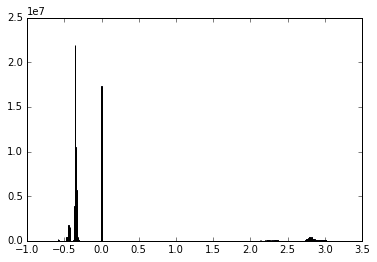

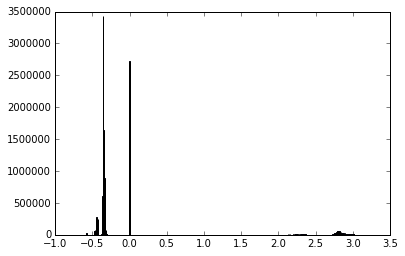

In [10]:
edge_mean = np.mean(train_edges, axis = 0)
train_edges = np.subtract(train_edges, edge_mean, casting="unsafe") # zero-center
test_edges = np.subtract(test_edges, edge_mean, casting="unsafe") # zero-center
edge_std = np.std(train_edges, axis = 0)
train_edges /= edge_std # normalize
test_edges /= edge_std

train_edges = np.nan_to_num(train_edges)
test_edges = np.nan_to_num(test_edges)

import matplotlib.pyplot as plt
hist, bins = np.histogram(train_edges, bins=1000)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

hist, bins = np.histogram(test_edges, bins=1000)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

Extracting features for x_train

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input, Conv2D, MaxPooling2D
from keras.models import Model
from keras.layers.merge import concatenate
from keras.optimizers import Adam

#baseline part
original_input = Input(shape=(32, 32, 4))
conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(original_input)
conv2 = Conv2D(64, (3, 3), activation='relu')(conv1)
max1 = MaxPooling2D(pool_size=(2, 2))(conv2)
drop1 = Dropout(0.25)(max1)
flat1 = Flatten()(drop1)
dense1 = Dense(128, activation='relu')(flat1)
drop2 = Dropout(0.5)(dense1)

edge_input = Input(shape=(32, 32, 4))
drop3 = Dropout(0.25)(edge_input)
flat2 = Flatten()(drop3)

combine = concatenate([drop2, flat2])
dense3 = Dense(256, activation='relu')(combine)
drop4 = Dropout(0.5)(dense3)
dense4 = Dense(17, activation='sigmoid', name='test')(drop4)



model = Model(inputs=[original_input, edge_input], outputs=dense4)

model.compile(loss='binary_crossentropy', # We NEED binary here, since categorical_crossentropy l1 norms the output before calculating loss.
                    optimizer='adam',
                    metrics=['accuracy'])

model.fit([x_train, train_edges], y_train, batch_size=128, 
          epochs=7, verbose=1, validation_data=([x_test, test_edges], y_test))

from sklearn.metrics import fbeta_score

p_valid = model.predict([x_test, test_edges], batch_size=128)
print(y_test)
print(p_valid)
print(fbeta_score(y_test, np.array(p_valid) > 0.2, beta=2, average='samples'))

Train on 35000 samples, validate on 5479 samples
Epoch 1/7
35000/35000 [==============================] - 278s - loss: 0.2718 - acc: 0.8969 - val_loss: 0.2074 - val_acc: 0.9209
Epoch 2/7
35000/35000 [==============================] - 269s - loss: 0.2003 - acc: 0.9231 - val_loss: 0.1796 - val_acc: 0.9296
Epoch 3/7
35000/35000 [==============================] - 272s - loss: 0.1741 - acc: 0.9331 - val_loss: 0.1696 - val_acc: 0.9352
Epoch 4/7
35000/35000 [==============================] - 286s - loss: 0.1588 - acc: 0.9392 - val_loss: 0.1625 - val_acc: 0.9390
Epoch 5/7
35000/35000 [==============================] - 302s - loss: 0.1471 - acc: 0.9433 - val_loss: 0.1595 - val_acc: 0.9403
Epoch 6/7
35000/35000 [==============================] - 284s - loss: 0.1370 - acc: 0.9469 - val_loss: 0.1580 - val_acc: 0.9403
Epoch 7/7
35000/35000 [==============================] - 263s - loss: 0.1294 - acc: 0.9495 - val_loss: 0.1568 - val_acc: 0.9414
[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 0]
 [0 0 1 ..., 0 

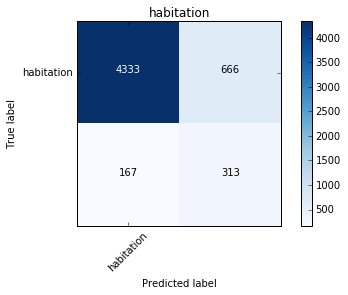

Stats for  habitation
Accuracy (true positive + true negative) / total:  0.847964957109
FPR (when actually no, how often does it say yes):  0.133226645329
TPR aka Recall (when actually yes, how often does it say yes):  0.652083333333
Precision (when predicts yes, how often is it right):  0.319713993871
Prevalence (how often does actual yes occur in sample):  0.0876072275963


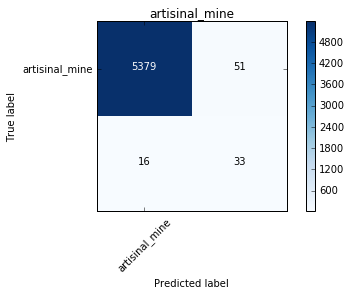

Stats for  artisinal_mine
Accuracy (true positive + true negative) / total:  0.987771491148
FPR (when actually no, how often does it say yes):  0.00939226519337
TPR aka Recall (when actually yes, how often does it say yes):  0.673469387755
Precision (when predicts yes, how often is it right):  0.392857142857
Prevalence (how often does actual yes occur in sample):  0.00894323781712


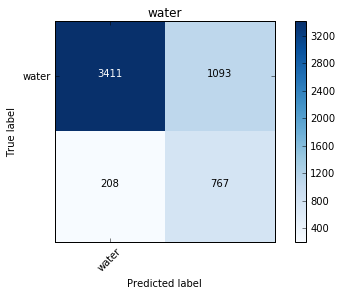

Stats for  water
Accuracy (true positive + true negative) / total:  0.762547910203
FPR (when actually no, how often does it say yes):  0.242673179396
TPR aka Recall (when actually yes, how often does it say yes):  0.786666666667
Precision (when predicts yes, how often is it right):  0.412365591398
Prevalence (how often does actual yes occur in sample):  0.177952181055


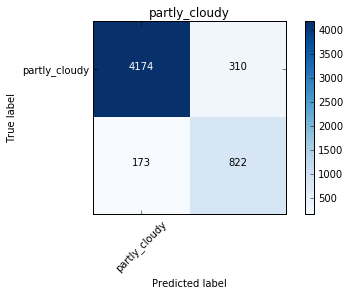

Stats for  partly_cloudy
Accuracy (true positive + true negative) / total:  0.911845227231
FPR (when actually no, how often does it say yes):  0.0691347011597
TPR aka Recall (when actually yes, how often does it say yes):  0.826130653266
Precision (when predicts yes, how often is it right):  0.726148409894
Prevalence (how often does actual yes occur in sample):  0.181602482205


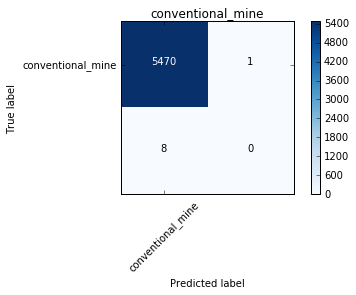

Stats for  conventional_mine
Accuracy (true positive + true negative) / total:  0.998357364483
FPR (when actually no, how often does it say yes):  0.000182781941144
TPR aka Recall (when actually yes, how often does it say yes):  0.0
Precision (when predicts yes, how often is it right):  0.0
Prevalence (how often does actual yes occur in sample):  0.00146012045994


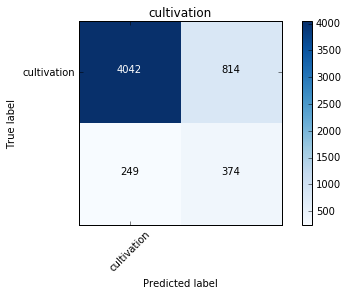

Stats for  cultivation
Accuracy (true positive + true negative) / total:  0.805986493886
FPR (when actually no, how often does it say yes):  0.1676276771
TPR aka Recall (when actually yes, how often does it say yes):  0.600321027287
Precision (when predicts yes, how often is it right):  0.314814814815
Prevalence (how often does actual yes occur in sample):  0.113706880818


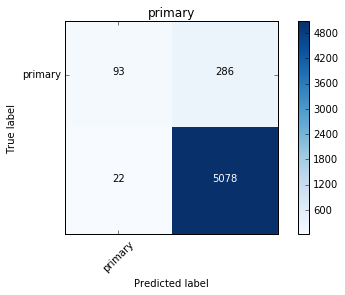

Stats for  primary
Accuracy (true positive + true negative) / total:  0.943785362292
FPR (when actually no, how often does it say yes):  0.754617414248
TPR aka Recall (when actually yes, how often does it say yes):  0.99568627451
Precision (when predicts yes, how often is it right):  0.94668158091
Prevalence (how often does actual yes occur in sample):  0.93082679321


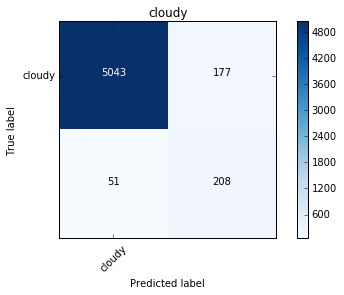

Stats for  cloudy
Accuracy (true positive + true negative) / total:  0.958386566892
FPR (when actually no, how often does it say yes):  0.033908045977
TPR aka Recall (when actually yes, how often does it say yes):  0.803088803089
Precision (when predicts yes, how often is it right):  0.54025974026
Prevalence (how often does actual yes occur in sample):  0.0472713998905


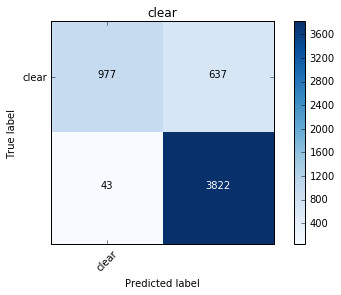

Stats for  clear
Accuracy (true positive + true negative) / total:  0.875889760905
FPR (when actually no, how often does it say yes):  0.394671623296
TPR aka Recall (when actually yes, how often does it say yes):  0.988874514877
Precision (when predicts yes, how often is it right):  0.857142857143
Prevalence (how often does actual yes occur in sample):  0.705420697208


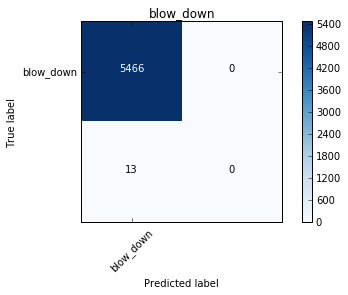

Stats for  blow_down
Accuracy (true positive + true negative) / total:  0.997627304253
FPR (when actually no, how often does it say yes):  0.0
TPR aka Recall (when actually yes, how often does it say yes):  0.0
Precision (when predicts yes, how often is it right):  nan
Prevalence (how often does actual yes occur in sample):  0.0023726957474


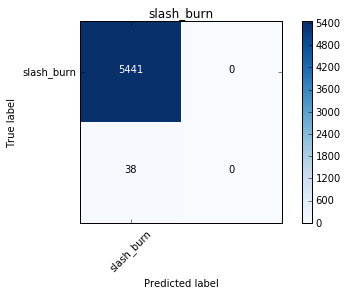

Stats for  slash_burn
Accuracy (true positive + true negative) / total:  0.993064427815
FPR (when actually no, how often does it say yes):  0.0
TPR aka Recall (when actually yes, how often does it say yes):  0.0
Precision (when predicts yes, how often is it right):  nan
Prevalence (how often does actual yes occur in sample):  0.00693557218471


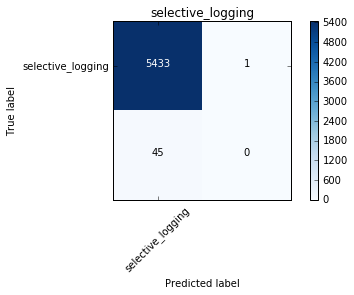

Stats for  selective_logging
Accuracy (true positive + true negative) / total:  0.991604307355
FPR (when actually no, how often does it say yes):  0.000184026499816
TPR aka Recall (when actually yes, how often does it say yes):  0.0
Precision (when predicts yes, how often is it right):  0.0
Prevalence (how often does actual yes occur in sample):  0.00821317758715


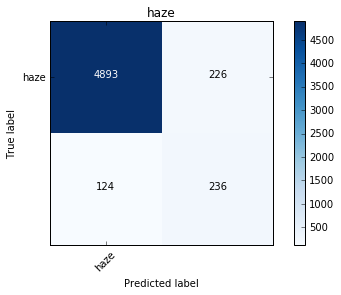

Stats for  haze
Accuracy (true positive + true negative) / total:  0.936119729878
FPR (when actually no, how often does it say yes):  0.0441492479
TPR aka Recall (when actually yes, how often does it say yes):  0.655555555556
Precision (when predicts yes, how often is it right):  0.510822510823
Prevalence (how often does actual yes occur in sample):  0.0657054206972


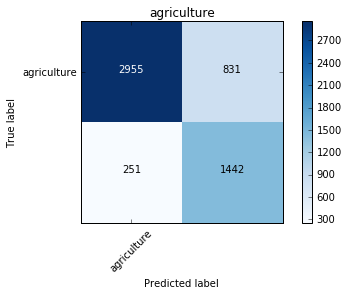

Stats for  agriculture
Accuracy (true positive + true negative) / total:  0.802518707793
FPR (when actually no, how often does it say yes):  0.219492868463
TPR aka Recall (when actually yes, how often does it say yes):  0.85174246899
Precision (when predicts yes, how often is it right):  0.634403871535
Prevalence (how often does actual yes occur in sample):  0.308997992334


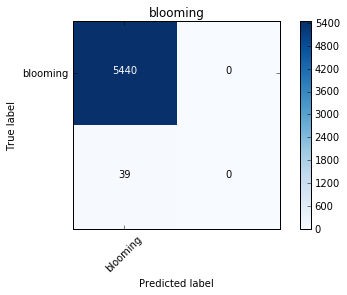

Stats for  blooming
Accuracy (true positive + true negative) / total:  0.992881912758
FPR (when actually no, how often does it say yes):  0.0
TPR aka Recall (when actually yes, how often does it say yes):  0.0
Precision (when predicts yes, how often is it right):  nan
Prevalence (how often does actual yes occur in sample):  0.0071180872422


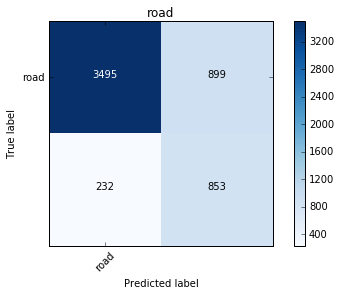

Stats for  road
Accuracy (true positive + true negative) / total:  0.793575469976
FPR (when actually no, how often does it say yes):  0.20459717797
TPR aka Recall (when actually yes, how often does it say yes):  0.786175115207
Precision (when predicts yes, how often is it right):  0.486872146119
Prevalence (how often does actual yes occur in sample):  0.198028837379


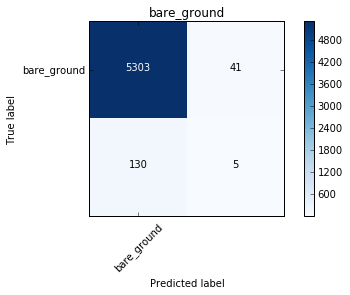

Stats for  bare_ground
Accuracy (true positive + true negative) / total:  0.968789925169
FPR (when actually no, how often does it say yes):  0.00767215568862
TPR aka Recall (when actually yes, how often does it say yes):  0.037037037037
Precision (when predicts yes, how often is it right):  0.108695652174
Prevalence (how often does actual yes occur in sample):  0.0246395327615


In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



for i in inv_label_map.keys():
    label = inv_label_map[i]
    cnf_matrix = confusion_matrix(y_test[:,i], p_valid[:,i]>0.2)
    plot_confusion_matrix(cnf_matrix, classes=[label], normalize=False,
                      title=label)
    total = cnf_matrix[0][0] + cnf_matrix[0][1] + cnf_matrix[1][0] + cnf_matrix[1][1]
    actualYes = cnf_matrix[1][0] + cnf_matrix[1][1]
    actualNo = cnf_matrix[0][0] + cnf_matrix[0][1]
    predYes = cnf_matrix[0][1] + cnf_matrix[1][1]
    plt.show()
    print("Stats for ", label)
    print("Accuracy (true positive + true negative) / total: ", (cnf_matrix[1][1] + cnf_matrix[0][0])/total)
    print("FPR (when actually no, how often does it say yes): ", cnf_matrix[0][1]/actualNo)
    print("TPR aka Recall (when actually yes, how often does it say yes): ", cnf_matrix[1][1]/actualYes)
    print("Precision (when predicts yes, how often is it right): ", cnf_matrix[1][1]/predYes)
    print("Prevalence (how often does actual yes occur in sample): ", actualYes/total)